Source Code from https://github.com/mikesmales/Udacity-ML-Capstone/blob/master/Notebooks/

In the earlier model using CNN, we were extracting each audio file as a floating point time series to train our model. However, this method does not capture envelope of the short time power spectrum characteristics of the audio. As such, we decided to use MFCC feature extraction function in Librosa to process our audio file and load it into our CNN model to see if model accuracy improved.

In [1]:
# Load various imports 
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

num_epochs = 100
num_batch_size = 32
seed = 29
np.random.seed(seed)

Based on the reference code provided above, we started our training by extracting MFCC feature of our audio file into 40 "bins".

In [2]:
n_mfcc = 40

def extract_audio_features_from(audio):
   
    try:
        sample_rate=22050
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e)
        return None 
     
    return mfccsscaled

import pickle
f=open('./data.pk','rb')
data = pickle.load(f)
print(data.head())



      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class                                            rawWave  \
0          dog_bark  ([-0.0034602168, -0.005025549, -0.004653247, -...   
1  children_playing  ([0.002732961, 0.0036436305, 0.0023043123, 0.0...   
2  children_playing  ([-0.0027075084, -0.0030330168, -0.001595565, ...   
3  children_playing  ([0.00014314766, -0.00022372589, -0.0013724423...   
4  children_playing  ([0.0012484171, 0.0042897766, 0.006238948, 0.0...   

                                                wave  len_wave  
0  [-0.0034602168, -0.005025549, 

In [3]:
data['mfcc']=data['wave'].apply(extract_audio_features_from)

Let's take a look at MFCC spectrogram of 2 audio files, namely Children Playing and Gun Shot. 

Childen Playing


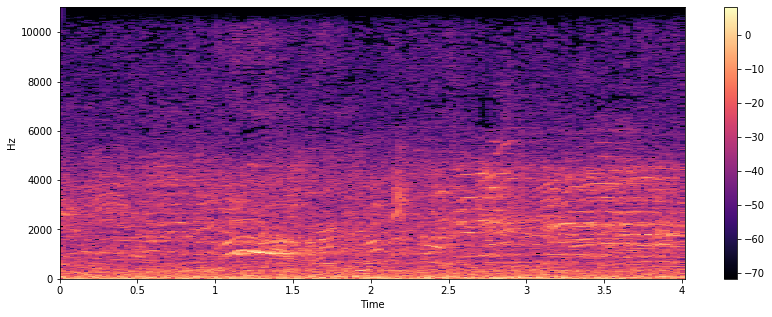

Gun Shot


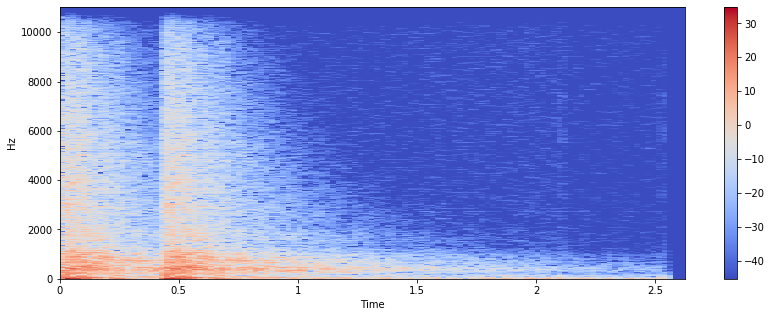

In [4]:
#display Spectrogram
def display_spectrogram(audio):
    X = librosa.stft(audio)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=22050, x_axis='time', y_axis='hz') 
    #If to pring log of frequencies  
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()

print("Childen Playing")
sample_wave = data.loc[data['slice_file_name']=='100263-2-0-121.wav']['wave'].apply(display_spectrogram)

print("Gun Shot")
sample_wave = data.loc[data['slice_file_name']=='102305-6-0-0.wav']['wave'].apply(display_spectrogram)

You can see these 2 audio files have very different spectrogram where gunshot has a high pitch at the beginning of the audio file. With that, we will start training our model. 

In [5]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(data.mfcc.tolist())
y = np.array(data['class'].tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

We split the dataset to 70%, 20% and 10% for training, validation and testing purpose respectively.

In [6]:
# split the dataset to train, validate and test set

mask = np.random.rand(len(data))
train_mask = mask < 0.7
validation_mask = np.logical_and(mask > 0.7, mask < 0.9)
test_mask = mask > 0.9

x_train = X[train_mask]
x_valid = X[validation_mask]
x_test = X[test_mask]
y_train = yy[train_mask]
y_valid = yy[validation_mask]
y_test = yy[test_mask]

For the training, we are using a CNN model. As the model is to predict and classify to 10 audio classes, our model final output layer will be 10.

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Dense(256, input_shape=(n_mfcc,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime 


checkpointer = ModelCheckpoint(filepath='weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_valid, y_valid), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6088 samples, validate on 1724 samples
Epoch 1/100
5760/6088 [===========================>..] - ETA: 0s - loss: 2.7398 - acc: 0.1332
Epoch 00001: val_loss improved from inf to 2.22328, saving model to weights.best.basic_mlp.hdf5
6088/6088 [==============================] - 1s 201us/sample - loss: 2.7145 - acc: 0.1329 - val_loss: 2.2233 - val_acc: 0.1508
Epoch 2/100
5760/6088 [===========================>..] - ETA: 0s - loss: 2.1680 - acc: 0.2097
Epoch 00002: val_loss improved from 2.22328 to 2.06893, saving model to weights.best.basic_mlp.hdf5
6088/6088 [==============================] - 1s 160us/sample - loss: 2.1680 - acc: 0.2080 - val_loss: 2.0689 - val_acc: 0.2877
Epoch 3/100
6080/6088 [============================>.] - ETA: 0s - loss: 2.0078 - acc: 0.2829
Epoch 00003: val_loss improved from 2.06893 to 1.79231, saving model to weights.best.basic_mlp.hdf5
6088/6088 [==============================] - 1s 163us/sample - loss: 2.0073 - acc: 0.2829 - val_loss: 1.7923 - val_acc: 

In [10]:

# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.92509854
Testing Accuracy:  0.8630435


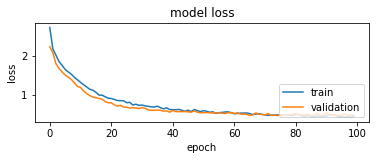

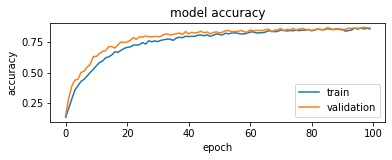

In [11]:
import matplotlib.pyplot as plt
#records = pd.read_csv(modelname + '.csv')
plt.figure()
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
ax = plt.gca()
ax.set_xticklabels([])
plt.subplot(212)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [17]:
predicts = model.predict(x_test, batch_size=2)
predout = np.argmax(predicts, axis=1)
testout = data[test_mask]['classID']
testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=data['class'].unique(),digits=4))

Best accuracy (on testing dataset): 86.30%
                  precision    recall  f1-score   support

        dog_bark     0.8750    0.9722    0.9211       108
children_playing     0.9000    0.7500    0.8182        48
        car_horn     0.6806    0.8305    0.7481       118
 air_conditioner     0.8304    0.8455    0.8378       110
    street_music     0.9394    0.8942    0.9163       104
        gun_shot     0.9444    0.9341    0.9392        91
           siren     0.8929    0.5435    0.6757        46
   engine_idling     0.9565    0.9565    0.9565        92
      jackhammer     0.9623    0.9273    0.9444       110
        drilling     0.7753    0.7419    0.7582        93

        accuracy                         0.8630       920
       macro avg     0.8757    0.8396    0.8516       920
    weighted avg     0.8696    0.8630    0.8624       920



Text(0.5, 23.09375, 'Predicted Label')

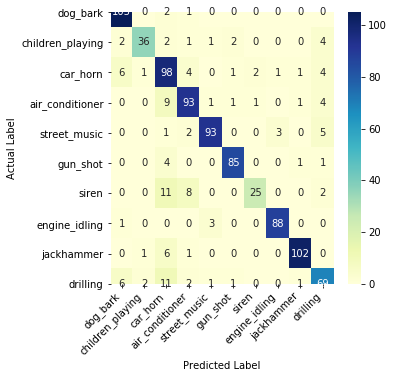

In [20]:
import seaborn as sn
df_cm = pd.DataFrame(confusion, index = data['class'].unique(),
                  columns = data['class'].unique())
plt.figure(figsize=(5,5))
ax=sn.heatmap(df_cm, cmap="YlGnBu", fmt="d", annot=True)
ax.set_xticklabels(
   ax.get_xticklabels(),
   rotation=45,
   horizontalalignment='right'
)
ax.set_ylabel("Actual Label")
ax.set_xlabel("Predicted Label")

Using MFCC features of the audio files for training, has improved the model overall accuracy, from 24.26% to 86.30%. And looking at the confusion matrix, we can only a small number of audio files were missed classified. Let's take a quick look

Drilling


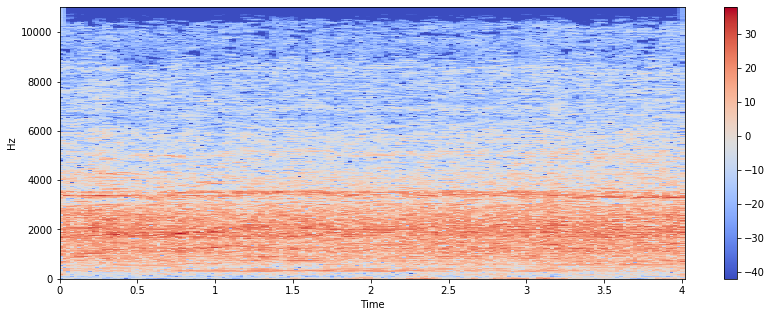

Car Horn


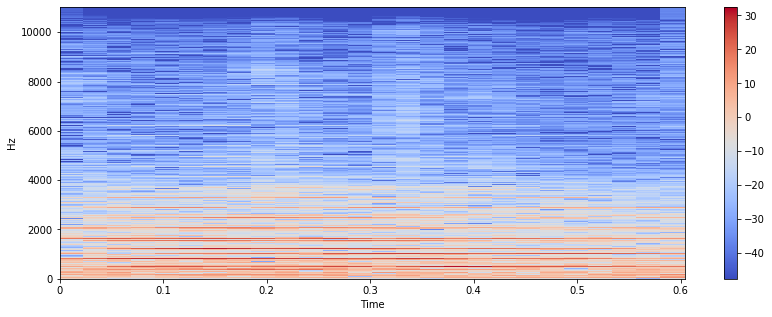

In [21]:
print("Drilling")
sample_wave = data.loc[data['slice_file_name']=='103199-4-2-4.wav']['wave'].apply(display_spectrogram)

print("Car Horn")
sample_wave = data.loc[data['slice_file_name']=='107090-1-0-0.wav']['wave'].apply(display_spectrogram)

In [14]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, sr=22050, mono=True) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [15]:
def print_prediction(file_name):
    mfcc_feature = extract_features(file_name) 
    prediction_feature = np.array([mfcc_feature])

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(f"{category[0]} \t\t : {format((predicted_proba[i])*100, '.2f')}%")

With the classifier model, we are going to test it using a audio file where we created by overlaying a gunshot audio on top of a children playing audio at 6.5 seconds. Here is what the MFCC spectrogram looks like:

Mixed audio of children playing and gun shot


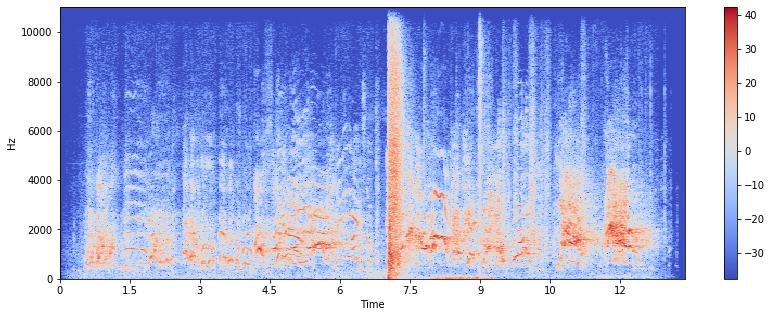

In [22]:
predfile = './testdata/mixedaudio2.wav'
pred_audio, pred_sample_rate = librosa.load(predfile, sr=22050, mono=True) 
print("Mixed audio of children playing and gun shot")
display_spectrogram(pred_audio)

In [16]:
print_prediction(predfile)

The predicted class is: children_playing 

air_conditioner 		 : 0.03%
car_horn 		 : 0.02%
children_playing 		 : 69.43%
dog_bark 		 : 15.47%
drilling 		 : 0.48%
engine_idling 		 : 0.45%
gun_shot 		 : 11.01%
jackhammer 		 : 0.00%
siren 		 : 2.32%
street_music 		 : 0.80%


Using this current model (with overall accuracy of 86.30%), we were about to identify the presence of gunshot sound within the children playing. But we wonder if we can improve the model accuracy further by increasing the number of MFCC bins. We will look at this in the next notebook.